<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/slakonet_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SlaKoNet: A Unified Slater-Koster Tight-Binding Framework Using Neural Network Infrastructure for the Periodic Table

References:
1. https://pubs.acs.org/doi/10.1021/acs.jpclett.5c02456
2. https://doi.org/10.1016/j.commatsci.2025.114063

# Table of contents

1. Install SlakoNet with Pypi or Git
2. Command line prediction examples (bulk and doped SiC)
3. Python Script example
4. Finetune model on your own dataset


Author: Kamal Choudhary (kchoudh2@jhu.edu)

Do you have any suggestions/requests for other tools? Raise a GitHub [issue](https://github.com/atomgptlab/slakonet/issues/new)

WebApp: https://atomgpt.org/slakonet (For #atoms<50)

In [1]:
!pip install -q git+https://github.com/atomgptlab/slakonet.git@develop

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 72.7 MB/s eta 0:00:00


In [2]:
pos="""Si4C4
1.0
1.549892767326361 -2.684493224977372 0.0
1.549892767326361 2.684493224977372 0.0
0.0 0.0 10.151391815821647
Si C
4  4
Cartesian
1.54989 -0.8948317896599827 9.52045238045808
1.54989 0.8948317896599827 4.444757380458079
0.0 0.0 6.982616849916004
0.0 0.0 1.9069218499160046
1.54989 -0.8948317896599827 7.6117778219678485
1.54989 0.8948317896599827 2.536082821967849
0.0 0.0 5.080550587658042
0.0 0.0 0.0048555876580418525
"""
with open('POSCAR-SiC.vasp','w') as f:
  f.write(pos)

# Command line example

In [3]:
!python -m slakonet.predict_slakonet --file_path POSCAR-SiC.vasp

100% 183M/183M [00:12<00:00, 14.8MiB/s]
Saved zip file: /usr/local/lib/python3.12/dist-packages/slakonet/slakonet_v0/slakonet_v0.zip
Extracting model file...
Extracted model to: /usr/local/lib/python3.12/dist-packages/slakonet/slakonet_v0/slakonet_v0.pt
Grouping parameters by pair...
Parameter grouping took: 0.09s
Creating 4095 SKF optimizers...
Optimizer creation took: 0.92s
State dict loading took: 18.62s
✅ Compact model loaded from: /usr/local/lib/python3.12/dist-packages/slakonet/slakonet_v0/slakonet_v0.pt
Total time: 24.23s
/usr/local/lib/python3.12/dist-packages/jarvis/analysis/structure/spacegroup.py:315: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  n = self._dataset["number"]
potential_energy 0
electronic_energy tensor(-318.9223, device='cuda:0')
/usr/local/lib/python3.12/dist-packages/slakonet/predict_slakonet.py:404: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you e

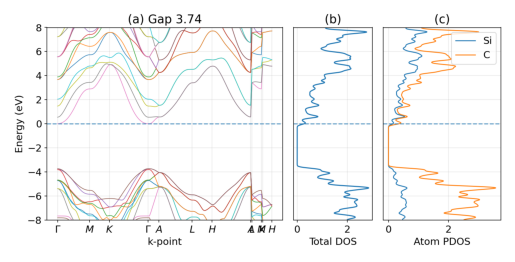

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(plt.imread('slakonet_bands_dos.png'))
plt.axis('off')
plt.show()



In [6]:
#Results stored in results.json
!ls results.json

results.json


In [7]:
from jarvis.core.atoms import Atoms
atoms=Atoms.from_poscar('POSCAR-SiC.vasp')

# Script Example

Loading cached model from /usr/local/lib/python3.12/dist-packages/slakonet/slakonet_v0/slakonet_v0.pt
Grouping parameters by pair...
Parameter grouping took: 0.06s
Creating 4095 SKF optimizers...
Optimizer creation took: 0.48s
State dict loading took: 21.49s
✅ Compact model loaded from: /usr/local/lib/python3.12/dist-packages/slakonet/slakonet_v0/slakonet_v0.pt
Total time: 25.19s
potential_energy 0
electronic_energy tensor(-318.9223, device='cuda:0')
Band gap : 3.739 eV
CBM      : -0.742 eV
VBM      : -4.481 eV


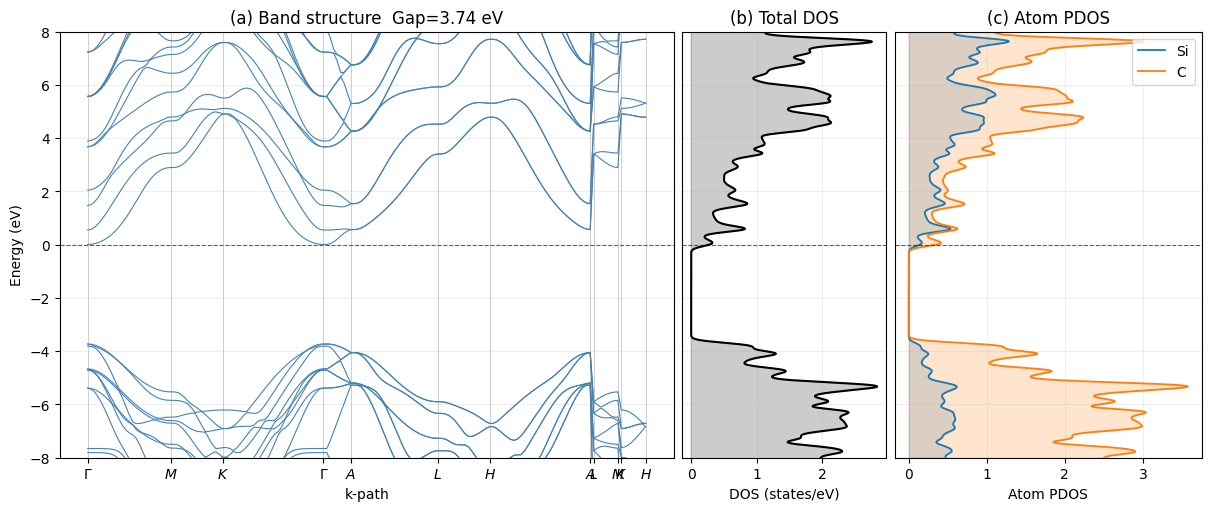

Saved → slakonet_bands_dos.png
CPU times: user 52.9 s, sys: 369 ms, total: 53.2 s
Wall time: 57 s


In [21]:
%%time
import matplotlib.pyplot as plt
import numpy as np
import torch
from jarvis.core.atoms import Atoms
from jarvis.core.kpoints import Kpoints3D as Kpoints
from slakonet.optim import (
    MultiElementSkfParameterOptimizer,
    get_atoms,
    kpts_to_klines,
    default_model,
)
from slakonet.atoms import Geometry
from slakonet.main import generate_shell_dict_upto_Z65
%matplotlib inline

# ── 1. Load structure ────────────────────────────────────────────────────────
# Option A: from JARVIS-DFT id
# atoms, opt_gap, mbj_gap = get_atoms(jid="JVASP-107")

# Option B: from local file
atoms = Atoms.from_poscar("POSCAR-SiC.vasp")

# ── 2. Load model ────────────────────────────────────────────────────────────
model = default_model()          # pretrained universal model
# model = MultiElementSkfParameterOptimizer.load_ultra_compact("my_model_path")
model = model.float().eval()

device = "cuda" if torch.cuda.is_available() else "cpu"

# ── 3. Build inputs ──────────────────────────────────────────────────────────
geometry   = Geometry.from_ase_atoms([atoms.ase_converter()])
shell_dict = generate_shell_dict_upto_Z65()
kpoints    = Kpoints().kpath(atoms, line_density=20)
klines     = kpts_to_klines(kpoints.kpts, default_points=2)

# ── 4. Run inference ─────────────────────────────────────────────────────────
with torch.no_grad():
    properties, success = model.compute_multi_element_properties(
        geometry=geometry,
        shell_dict=shell_dict,
        klines=klines,
        get_fermi=True,
        with_eigenvectors=True,
        device=device,
    )
assert success, "Property calculation failed"

# ── 5. Extract key quantities ────────────────────────────────────────────────
bandgap     = float(properties["bandgap"].detach().cpu())
eigenvalues = properties["eigenvalues"].detach().cpu().numpy()   # [1, nk, nb]
dos_values  = properties["dos_values_tensor"].detach().cpu().numpy()
dos_energies= properties["dos_energy_grid_tensor"].detach().cpu().numpy()
geometry_out= properties["geometry"]

print(f"Band gap : {bandgap:.3f} eV")
print(f"CBM      : {float(properties['cbm'].detach().cpu()):.3f} eV")
print(f"VBM      : {float(properties['vbm'].detach().cpu()):.3f} eV")

# ── 6. k-point tick labels ───────────────────────────────────────────────────
def format_kpath_ticks(labels):
    xticks, xtick_labels, last = [], [], None
    for i, lbl in enumerate(labels):
        if not lbl or not lbl.strip():
            continue
        show = r"$\Gamma$" if lbl in ("G", r"\Gamma", "Γ") else rf"${lbl}$"
        if show != last:
            xticks.append(i)
            xtick_labels.append(show)
            last = show
    return xticks, xtick_labels

xticks, xtick_labels = format_kpath_ticks(kpoints.labels)

# ── 7. Atom-projected DOS ────────────────────────────────────────────────────
def compute_atom_pdos(properties, geometry, sigma=0.1, energy_range=(-8, 8)):
    eigenvalues = properties["eigenvalues"]
    eigenvectors= properties["eigenvectors"]          # [1, nk, nb, norb]
    basis       = properties["basis"]
    atom_types  = geometry.chemical_symbols[0]
    unique_atoms= list(dict.fromkeys(atom_types))
    on_atoms    = basis.on_atoms[0].cpu().numpy()

    n_pts       = 1000
    egrid       = torch.linspace(*energy_range, n_pts, device=eigenvalues.device)
    atom_pdos   = {a: torch.zeros(n_pts, device=eigenvalues.device) for a in unique_atoms}

    orb2atom = [atom_types[on_atoms[i]] for i in range(len(on_atoms))]
    atom_orb_map = {a: [i for i, t in enumerate(orb2atom) if t == a] for a in unique_atoms}

    norm = 1.0 / (sigma * np.sqrt(2 * np.pi))
    _, nk, nb = eigenvalues.shape
    for k in range(nk):
        for b in range(nb):
            eval = eigenvalues[0, k, b]
            psi  = eigenvectors[0, k, b, :]
            g    = norm * torch.exp(-0.5 * ((egrid - eval) / sigma) ** 2)
            for atom in unique_atoms:
                w = torch.sum(torch.abs(psi[atom_orb_map[atom]]) ** 2)
                atom_pdos[atom] += w * g

    for atom in atom_pdos:
        atom_pdos[atom] /= nk

    energy_np   = egrid.detach().cpu().numpy()
    atom_pdos_np= {a: v.detach().cpu().numpy() for a, v in atom_pdos.items()}
    return energy_np, atom_pdos_np, unique_atoms

energy_range = (-8, 8)
egrid, atom_pdos, unique_atoms = compute_atom_pdos(
    properties, geometry_out, energy_range=energy_range
)

# ── 8. Plot: bands | total DOS | atom PDOS ───────────────────────────────────
fig = plt.figure(figsize=(12, 5), layout="constrained")
gs  = fig.add_gridspec(1, 3, width_ratios=[3, 1, 1.5])
ax1, ax2, ax3 = fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2])

# Band structure
for i in range(eigenvalues.shape[-1]):
    ax1.plot(eigenvalues[0, :, i].real, linewidth=0.8, color="steelblue")
ax1.axhline(0, linestyle="--", color="k", alpha=0.6, linewidth=0.8)
for x in xticks:
    ax1.axvline(x, color="gray", linewidth=0.5, alpha=0.4)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xtick_labels)
ax1.set_ylabel("Energy (eV)")
ax1.set_xlabel("k-path")
ax1.set_ylim(energy_range)
ax1.set_title(f"(a) Band structure  Gap={bandgap:.2f} eV")
ax1.grid(True, alpha=0.2)

# Total DOS
ax2.plot(dos_values, dos_energies, linewidth=1.5, color="k")
ax2.axhline(0, linestyle="--", color="k", alpha=0.6, linewidth=0.8)
ax2.fill_betweenx(dos_energies, 0, dos_values, alpha=0.2, color="k")
ax2.set_xlabel("DOS (states/eV)")
ax2.set_ylim(energy_range)
ax2.set_title("(b) Total DOS")
ax2.tick_params(left=False, labelleft=False)
ax2.grid(True, alpha=0.2)

# Atom-projected DOS
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for idx, atom in enumerate(unique_atoms):
    ax3.plot(atom_pdos[atom], egrid, linewidth=1.3, label=atom, color=colors[idx])
    ax3.fill_betweenx(egrid, 0, atom_pdos[atom], alpha=0.2, color=colors[idx])
ax3.axhline(0, linestyle="--", color="k", alpha=0.6, linewidth=0.8)
ax3.set_xlabel("Atom PDOS")
ax3.set_ylim(energy_range)
ax3.set_title("(c) Atom PDOS")
ax3.tick_params(left=False, labelleft=False)
ax3.legend(loc="upper right", fontsize=10)
ax3.grid(True, alpha=0.2)

plt.savefig("slakonet_bands_dos.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved → slakonet_bands_dos.png")

In [22]:
properties.keys()

dict_keys(['energy', 'eigenvalues', 'fermi_energy', 'electronic_energy', 'potential_energy', 'forces', 'stress', 'bandgap', 'cbm', 'vbm', 'occupations', 'geometry', 'basis', 'dos_at_fermi', 'dos_gap_center_eV', 'dos_total_states', 'dos_at_fermi_tensor', 'dos_gap_center_tensor', 'dos_total_states_tensor', 'dos_energy_grid_tensor', 'dos_values_tensor', 'hamiltonian', 'overlap', 'eigenvectors', 'charges'])

In [23]:
properties['bandgap'][0]

tensor(3.7394, device='cuda:0')

In [26]:
%%time
import os
# !pip install -q slakonet
os.mkdir('/content/Software')
os.chdir('/content/Software')
if not os.path.exists('slakonet'):
   !git clone https://github.com/atomgptlab/slakonet.git
os.chdir("slakonet")
!git checkout develop
# !pip install -q -e .
os.chdir('/content')

Cloning into 'slakonet'...
remote: Enumerating objects: 498, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 498 (delta 124), reused 112 (delta 65), pack-reused 321 (from 1)
Receiving objects: 100% (498/498), 7.17 MiB | 10.44 MiB/s, done.
Resolving deltas: 100% (308/308), done.
Branch 'develop' set up to track remote branch 'develop' from 'origin'.
Switched to a new branch 'develop'
CPU times: user 12 ms, sys: 3.03 ms, total: 15 ms
Wall time: 1.83 s


In [27]:
!ls /content/Software/slakonet/slakonet/examples

config_example.json
ES-SinglePropertyPrediction-bandgap-dft_3d-test-mae.csv
fig3d_pred_analysis.py
plot_fig2.py
plot_fig3.py
plot_fig3v2.py
plot_fig5.py
POSCAR-AlN-GaN.vasp
POSCAR-JVASP-107.vasp
POSCAR-Si-amor.vasp
POSCAR-SiC-3C-3x3x3N.vasp
POSCAR-SiC-3C-3x3x3.vasp
POSCAR-SiC-3C.vasp
POSCAR-Si-GaAs.vasp
run_inference.py
scale2.py
scale.py
sk_schematic.png
slakonet_bands_dos.png
timing.png


## Command line prediction example (Nitrogen doped SiC)

In [29]:
!python -m slakonet.predict_slakonet --file_path /content/Software/slakonet/slakonet/examples/POSCAR-SiC-3C-3x3x3N.vasp

Loading cached model from /usr/local/lib/python3.12/dist-packages/slakonet/slakonet_v0/slakonet_v0.pt
Grouping parameters by pair...
Parameter grouping took: 0.05s
Creating 4095 SKF optimizers...
Optimizer creation took: 0.88s
State dict loading took: 23.13s
✅ Compact model loaded from: /usr/local/lib/python3.12/dist-packages/slakonet/slakonet_v0/slakonet_v0.pt
Total time: 26.66s
/usr/local/lib/python3.12/dist-packages/jarvis/analysis/structure/spacegroup.py:315: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  n = self._dataset["number"]
potential_energy 0
electronic_energy tensor(-2197.2998, device='cuda:0')
/usr/local/lib/python3.12/dist-packages/slakonet/predict_slakonet.py:404: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bandgap = float(properties["bandgap"].detach().cpu

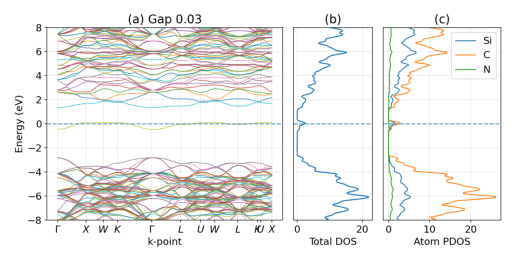

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(plt.imread('slakonet_bands_dos.png'))
plt.axis('off')
plt.show()



In [34]:
# Finetune model on your own dataset
# import os
# os.chdir('/content/Software/slakonet')
# # Adjust xml_folder_path in your config_example.json
# !python -m slakonet.train_slakonet --config_name /content/Software/slakonet/slakonet/examples/config_example.json

# Scaling test

Loading cached model from /usr/local/lib/python3.12/dist-packages/slakonet/slakonet_v0/slakonet_v0.pt
Grouping parameters by pair...
Parameter grouping took: 0.07s
Creating 4095 SKF optimizers...
Optimizer creation took: 0.92s
State dict loading took: 21.19s
✅ Compact model loaded from: /usr/local/lib/python3.12/dist-packages/slakonet/slakonet_v0/slakonet_v0.pt
Total time: 24.59s
Obtaining 3D dataset 76k ...
Reference:https://doi.org/10.1016/j.commatsci.2025.114063
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|██████████| 40.8M/40.8M [00:03<00:00, 11.3MiB/s]


Loading the zipfile...
Loading completed.


Supercell scaling:   0%|          | 0/8 [00:00<?, ?it/s]

potential_energy 0
electronic_energy tensor(-70.2247)
potential_energy 0
electronic_energy tensor(-70.2247, device='cuda:0')


Supercell scaling:  12%|█▎        | 1/8 [00:33<03:55, 33.71s/it]

  sc= 1  N=    2  CPU=16.49s  GPU=17.22s
potential_energy 0
electronic_energy tensor(-573.9373)
potential_energy 0
electronic_energy tensor(-573.9373, device='cuda:0')


Supercell scaling:  25%|██▌       | 2/8 [01:08<03:24, 34.11s/it]

  sc= 2  N=   16  CPU=17.73s  GPU=16.65s
potential_energy 0
electronic_energy tensor(-1937.5074)
potential_energy 0
electronic_energy tensor(-1937.5076, device='cuda:0')


Supercell scaling:  38%|███▊      | 3/8 [01:43<02:52, 34.58s/it]

  sc= 3  N=   54  CPU=17.84s  GPU=17.28s
potential_energy 0
electronic_energy tensor(-4592.5479)
potential_energy 0
electronic_energy tensor(-4592.5479, device='cuda:0')


Supercell scaling:  50%|█████     | 4/8 [02:19<02:21, 35.39s/it]

  sc= 4  N=  128  CPU=18.94s  GPU=17.66s
potential_energy 0
electronic_energy tensor(-8969.7676)
potential_energy 0
electronic_energy tensor(-8969.7676, device='cuda:0')


Supercell scaling:  62%|██████▎   | 5/8 [03:00<01:52, 37.44s/it]

  sc= 5  N=  250  CPU=21.08s  GPU=19.96s
potential_energy 0
electronic_energy tensor(-15499.7285)
potential_energy 0
electronic_energy tensor(-15499.7285, device='cuda:0')


Supercell scaling:  75%|███████▌  | 6/8 [03:57<01:28, 44.05s/it]

  sc= 6  N=  432  CPU=29.84s  GPU=27.02s
potential_energy 0
electronic_energy tensor(-24612.9785)
potential_energy 0
electronic_energy tensor(-24612.9805, device='cuda:0')


Supercell scaling:  88%|████████▊ | 7/8 [05:31<01:00, 60.14s/it]

  sc= 7  N=  686  CPU=56.60s  GPU=36.63s
potential_energy 0
electronic_energy tensor(-36740.0664)
potential_energy 0
electronic_energy tensor(-36740.0625, device='cuda:0')


Supercell scaling: 100%|██████████| 8/8 [08:48<00:00, 66.04s/it] 

  sc= 8  N= 1024  CPU=132.42s  GPU=64.83s

num_atoms  : [2, 16, 54, 128, 250, 432, 686, 1024]
times_cpu  : ['16.493', '17.726', '17.836', '18.936', '21.083', '29.836', '56.602', '132.417']
times_gpu  : ['17.220', '16.652', '17.283', '17.656', '19.964', '27.018', '36.630', '64.829']


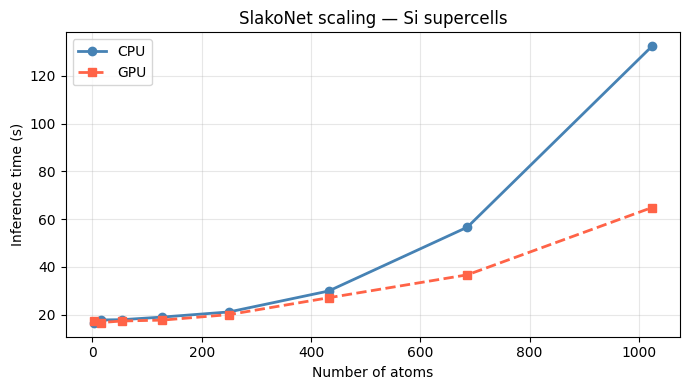

Saved → slakonet_scaling.png


In [35]:
%matplotlib inline
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from jarvis.core.atoms import Atoms
from jarvis.core.kpoints import Kpoints3D as Kpoints
from slakonet.atoms import Geometry
from slakonet.optim import (
    MultiElementSkfParameterOptimizer,
    get_atoms,
    kpts_to_klines,
    default_model,
)
from slakonet.main import generate_shell_dict_upto_Z65

# ── 1. Setup ─────────────────────────────────────────────────────────────────
model = default_model()
atoms, _, _ = get_atoms(jid="JVASP-1002")
shell_dict  = generate_shell_dict_upto_Z65()
kpoints     = torch.tensor([1, 1, 1])

has_gpu = torch.cuda.is_available()
scells  = [1, 2, 3, 4, 5, 6, 7, 8]

times_cpu, times_gpu, num_atoms = [], [], []

# ── 2. Scaling benchmark ──────────────────────────────────────────────────────
for i in tqdm(scells, desc="Supercell scaling"):
    supercell = atoms.make_supercell_matrix([i, i, i])
    geometry  = Geometry.from_ase_atoms([supercell.ase_converter()])
    n         = supercell.num_atoms
    num_atoms.append(n)

    # CPU timing
    with torch.no_grad():
        t1 = time.perf_counter()
        props, success = model.compute_multi_element_properties(
            geometry=geometry,
            shell_dict=shell_dict,
            kpoints=kpoints,
            get_energy=True,
            device="cpu",
        )
        times_cpu.append(time.perf_counter() - t1)

    # GPU timing (skip gracefully if unavailable)
    if has_gpu:
        with torch.no_grad():
            t1 = time.perf_counter()
            props, success = model.compute_multi_element_properties(
                geometry=geometry,
                shell_dict=shell_dict,
                kpoints=kpoints,
                get_energy=True,
                device="cuda",
            )
            times_gpu.append(time.perf_counter() - t1)
    else:
        times_gpu.append(float("nan"))

    print(f"  sc={i:2d}  N={n:5d}  CPU={times_cpu[-1]:.2f}s  GPU={times_gpu[-1]:.2f}s")

# ── 3. Print summary ──────────────────────────────────────────────────────────
print("\nnum_atoms  :", num_atoms)
print("times_cpu  :", [f"{t:.3f}" for t in times_cpu])
print("times_gpu  :", [f"{t:.3f}" for t in times_gpu])

# ── 4. Plot ───────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(num_atoms, times_cpu, "o-",  color="steelblue", linewidth=2,
        markersize=6, label="CPU")
if has_gpu:
    ax.plot(num_atoms, times_gpu, "s--", color="tomato", linewidth=2,
            markersize=6, label="GPU")

ax.set_xlabel("Number of atoms")
ax.set_ylabel("Inference time (s)")
ax.set_title(f"SlakoNet scaling — {atoms.composition.reduced_formula} supercells")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("slakonet_scaling.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved → slakonet_scaling.png")

In [38]:
%matplotlib inline
from tqdm import tqdm
import time
from jarvis.core.kpoints import Kpoints3D as Kpoints
from slakonet.atoms import Geometry
from slakonet.optim import get_atoms
import matplotlib.pyplot as plt
from slakonet.optim import (
    MultiElementSkfParameterOptimizer,
    get_atoms,
    kpts_to_klines,
    default_model,
)
from slakonet.main import generate_shell_dict_upto_Z65


model_best = default_model()

atoms, _, _ = get_atoms(jid="JVASP-1002")
shell_dict = generate_shell_dict_upto_Z65()
kpoints = torch.tensor([1, 1, 1])

scells = [1, 2, 3, 4, 5, 6, 7, 8] #, 9, 10]
# scells=[1,2,3,4,5]
times_gpu = []
times_cpu = []
nums = []
for i in scells:
    s = atoms.make_supercell_matrix([i, i, i])
    geometry = Geometry.from_ase_atoms([s.ase_converter()])
    with torch.no_grad():  # No gradients needed for inference
        t1 = time.time()
        properties, success = model_best.compute_multi_element_properties(
            geometry=geometry,
            shell_dict=shell_dict,
            kpoints=kpoints,
            get_energy=True,
            device="cpu",
        )
        en = properties["electronic_energy"]
        t2 = time.time()
        times_cpu.append(t2 - t1)
        # print(times_cpu[-1])
        nums.append(s.num_atoms)
    with torch.no_grad():  # No gradients needed for inference
        t1 = time.time()
        properties, success = model_best.compute_multi_element_properties(
            geometry=geometry,
            shell_dict=shell_dict,
            kpoints=kpoints,
            get_energy=True,
            device="cuda",
        )
        en = properties["electronic_energy"]
        t2 = time.time()
        times_gpu.append(t2 - t1)
        # print(times_gpu[-1])

    print("i,num,cpu,gpu", i, s.num_atoms, times_cpu[-1], times_gpu[-1])
print("nums", nums)
print("times_cpu", times_cpu)
print("times_gpu", times_gpu)

Loading cached model from /usr/local/lib/python3.12/dist-packages/slakonet/slakonet_v0/slakonet_v0.pt
Grouping parameters by pair...
Parameter grouping took: 0.06s
Creating 4095 SKF optimizers...
Optimizer creation took: 1.09s
State dict loading took: 20.22s
✅ Compact model loaded from: /usr/local/lib/python3.12/dist-packages/slakonet/slakonet_v0/slakonet_v0.pt
Total time: 24.73s
Obtaining 3D dataset 76k ...
Reference:https://doi.org/10.1016/j.commatsci.2025.114063
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
potential_energy 0
electronic_energy tensor(-70.2247)
potential_energy 0
electronic_energy tensor(-70.2247, device='cuda:0')
i,num,cpu,gpu 1 2 16.856229782104492 18.40798330307007
potential_energy 0
electronic_energy tensor(-573.9373)
potential_energy 0
electronic_energy tensor(-573.9373, device='cuda:0')
i,num,cpu,gpu 2 16 17.178065538406372 17.869707822799683
potential_energy 0
electronic_energy tensor(-1937.5074)
potential

In [37]:
properties.keys()

dict_keys(['energy', 'eigenvalues', 'fermi_energy', 'electronic_energy', 'potential_energy', 'forces', 'stress', 'bandgap', 'cbm', 'vbm', 'occupations', 'geometry', 'basis', 'dos_at_fermi', 'dos_gap_center_eV', 'dos_total_states', 'dos_at_fermi_tensor', 'dos_gap_center_tensor', 'dos_total_states_tensor', 'dos_energy_grid_tensor', 'dos_values_tensor', 'hamiltonian', 'overlap'])

In [ ]:
# %matplotlib inline
# from tqdm import tqdm
# import time
# from jarvis.core.kpoints import Kpoints3D as Kpoints
# from slakonet.atoms import Geometry
# from slakonet.optim import get_atoms
# import matplotlib.pyplot as plt
# from slakonet.optim import (
#     MultiElementSkfParameterOptimizer,
#     get_atoms,
#     kpts_to_klines,
#     default_model,
# )
# from slakonet.main import generate_shell_dict_upto_Z65


# model_best = default_model()

# atoms, _, _ = get_atoms(jid="JVASP-1002")
# shell_dict = generate_shell_dict_upto_Z65()
# kpoints = torch.tensor([1, 1, 1])

# scells = [1, 2, 3, 4, 5, 6, 7, 8] #, 9, 10]
# # scells=[1,2,3,4,5]
# times_gpu = []
# times_cpu = []
# nums = []
# for i in scells:
#     s = atoms.make_supercell_matrix([i, i, i])
#     geometry = Geometry.from_ase_atoms([s.ase_converter()])
#     with torch.no_grad():  # No gradients needed for inference
#         t1 = time.time()
#         properties, success = model_best.compute_multi_element_properties(
#             geometry=geometry,
#             shell_dict=shell_dict,
#             kpoints=kpoints,
#             get_energy=True,
#             device="cpu",
#         )
#         en = properties["total_energy"]
#         t2 = time.time()
#         times_cpu.append(t2 - t1)
#         # print(times_cpu[-1])
#         nums.append(s.num_atoms)
#     with torch.no_grad():  # No gradients needed for inference
#         t1 = time.time()
#         properties, success = model_best.compute_multi_element_properties(
#             geometry=geometry,
#             shell_dict=shell_dict,
#             kpoints=kpoints,
#             get_energy=True,
#             device="cuda",
#         )
#         en = properties["total_energy"]
#         t2 = time.time()
#         times_gpu.append(t2 - t1)
#         # print(times_gpu[-1])

#     print("i,num,cpu,gpu", i, s.num_atoms, times_cpu[-1], times_gpu[-1])
# print("nums", nums)
# print("times_cpu", times_cpu)
# print("times_gpu", times_gpu)

Loading cached model from /content/Software/slakonet/slakonet/slakonet_v0/slakonet_v0.pt
✅ Compact model loaded from: /content/Software/slakonet/slakonet/slakonet_v0/slakonet_v0.pt
Time taken: 112.322
Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
i,num,cpu,gpu 1 2 8.73747730255127 9.469879627227783
i,num,cpu,gpu 2 16 10.042244911193848 9.32802128791809
i,num,cpu,gpu 3 54 9.9648277759552 8.542931318283081
i,num,cpu,gpu 4 128 9.88958191871643 10.633336782455444
i,num,cpu,gpu 5 250 12.710638999938965 11.298696279525757
i,num,cpu,gpu 6 432 24.089404821395874 15.25683307647705


In [ ]:
import torch
import sys
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 22})
# On H200
nums = [2, 16, 54, 128, 250, 432, 686, 1024, 1458, 2000]
times_cpu_h200 = [
    4.981168746948242,
    4.553197622299194,
    4.88469934463501,
    5.553440093994141,
    7.160606145858765,
    13.558997869491577,
    34.77856516838074,
    99.5997314453125,
    255.79310011863708,
    631.9005651473999,
]
times_gpu_h200 = [
    5.525652647018433,
    4.9758460521698,
    4.890452861785889,
    5.127196788787842,
    5.881839990615845,
    7.848914384841919,
    12.485913515090942,
    22.772614002227783,
    41.18002128601074,
    75.67503428459167,
]

# plt.plot(nums, times_cpu)
# plt.plot(nums, times_gpu)
# plt.tight_layout("times.png")
# plt.close()

# sys.exit()